In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlibp inline

Populating the interactive namespace from numpy and matplotlib


UsageError: Line magic function `%matplotlibp` not found.


# 0. Import Module

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
import numpy as np
from numpy import linalg
from torchsummary import summary
from torchvision import transforms                                                                                                                                        

import matplotlib as mpl
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
mpl.rcParams['figure.dpi'] = 600

from PIL import Image
#import seaborn as sns
#sns.set(color_codes=True)

import sys
sys.path.append("../src/")
import model
from datasets import imagenet
import config
from aux.utils import obtain_features_map, load_imgs, zscore, extract_valid
from aux.visualization import visualize_features_map_for_comparision

# 1.Hyperparameter & Load model from Dict

In [3]:
resume = "037-0"
model_dir = "../saved/models"
generated_dir = "../saved/generated/"
backbone = "vgg16"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model
net = model.Network(backbone=backbone, num_classes=1000)
net.to(device)

# resume from model
resume_exp = resume.split("-")[0]
resume_epoch = resume.split("-")[1]
print("Resume from model from exp: {} at epoch {}".format(resume_exp, resume_epoch))
resume_path = os.path.join(model_dir, str(resume_exp), str(resume_epoch))
ckpt = torch.load(resume_path, map_location=device)
net.load_state_dict(ckpt) 

summary(net, (3, 224, 224))

> Use original fc
Resume from model from exp: 037 at epoch 0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56

In [4]:
params = {}
conv_index = 1
linear_index = 1
for name, param in net.named_parameters():
    if "features" in name and "weight" in name: 
        conv_name = "conv-{}".format(conv_index)
        print(name, conv_name, param.size())
        conv_index = conv_index + 1
        params[conv_name] = param.detach().cpu()
    if not "features" in name and "weight" in name: 
        linear_name = "linear-{}".format(linear_index)
        print(name, linear_name, param.size())
        linear_index = linear_index + 1
        params[linear_name] = param.detach().cpu()

model.features.0.weight conv-1 torch.Size([64, 3, 3, 3])
model.features.2.weight conv-2 torch.Size([64, 64, 3, 3])
model.features.5.weight conv-3 torch.Size([128, 64, 3, 3])
model.features.7.weight conv-4 torch.Size([128, 128, 3, 3])
model.features.10.weight conv-5 torch.Size([256, 128, 3, 3])
model.features.12.weight conv-6 torch.Size([256, 256, 3, 3])
model.features.14.weight conv-7 torch.Size([256, 256, 3, 3])
model.features.17.weight conv-8 torch.Size([512, 256, 3, 3])
model.features.19.weight conv-9 torch.Size([512, 512, 3, 3])
model.features.21.weight conv-10 torch.Size([512, 512, 3, 3])
model.features.24.weight conv-11 torch.Size([512, 512, 3, 3])
model.features.26.weight conv-12 torch.Size([512, 512, 3, 3])
model.features.28.weight conv-13 torch.Size([512, 512, 3, 3])
model.fc.0.weight linear-1 torch.Size([4096, 25088])
model.fc.3.weight linear-2 torch.Size([4096, 4096])
model.fc.6.weight linear-3 torch.Size([1000, 4096])


In [28]:
print(params["conv-1"][16])
print(torch.norm(params["conv-1"][16][0], p=1))
print(torch.norm(params["conv-1"][16][1], p=1))
print(torch.norm(params["conv-1"][16][2], p=1))
print("Bias:", net.model.features[0].bias[16])

tensor([[[-0.0105, -0.0312, -0.0467],
         [ 0.0832,  0.1357, -0.0409],
         [-0.0506,  0.0167, -0.0300]],

        [[ 0.0397,  0.1204,  0.1814],
         [ 0.1610,  0.3481,  0.1696],
         [-0.0267,  0.0891,  0.1146]],

        [[-0.0538, -0.3540, -0.2207],
         [-0.0722, -0.3521, -0.3450],
         [ 0.1028, -0.1339, -0.0159]]])
tensor(0.4453)
tensor(1.2505)
tensor(1.6505)
Bias: tensor(0.0460, device='cuda:0', grad_fn=<SelectBackward>)


In [27]:
print(params["conv-1"][47])
print(torch.norm(params["conv-1"][47][0], p=1))
print(torch.norm(params["conv-1"][47][1], p=1))
print(torch.norm(params["conv-1"][47][2], p=1))
print("Bias:", net.model.features[0].bias[47])

tensor([[[ 0.0743,  0.0443, -0.0495],
         [ 0.1431,  0.2238,  0.1433],
         [ 0.1259,  0.4145,  0.1221]],

        [[ 0.1761, -0.0929, -0.0066],
         [-0.1718, -0.4284, -0.2386],
         [-0.0672, -0.0529, -0.1531]],

        [[ 0.0542,  0.1074,  0.2152],
         [-0.1311, -0.1699,  0.0793],
         [-0.1936, -0.1020, -0.0568]]])
tensor(1.3409)
tensor(1.3877)
tensor(1.1094)
Bias: tensor(0.2612, device='cuda:0', grad_fn=<SelectBackward>)


In [62]:
def normalized_weights(params):
    normalized_weight = {}
    for name, layer in params.items():
        if "linear" in name:
            continue
        layer_norm = torch.norm(layer, p=1, dim=(1,2,3))
        layer_norm_sorted, indices = torch.sort(layer_norm, descending=True) 
        normalized_weight[name] = layer_norm_sorted / torch.max(layer_norm_sorted)
    return normalized_weight

In [64]:
normalized_weight = normalized_weights(params)

In [169]:
def plot_under_equal_xs(name, param):
    name_dash_line = ["conv-3", "conv-4", "conv-2"]
    linestyle = "--" if name in name_dash_line else "-"
    num = param.size()[0]
    xs = np.linspace(start=0, stop=100, num=num)
    plt.plot(xs, param.numpy(), label=name, linestyle=linestyle)

In [170]:
def filters_rank_figure(params):
    for name, param in params.items():
        plot_under_equal_xs(name, param)
    plt.title("ImageNet, VGG-16")
    plt.xlabel("filter index / # filter(%)")
    plt.ylabel("normalized abs sum of filter weight")
    plt.ylim(0.0, 1.0)
    plt.xlim((0,140))
    plt.legend()
    plt.show()

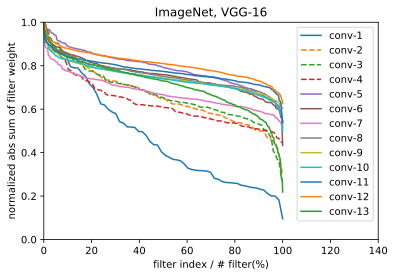

In [171]:
filters_rank_figure(noramlized_weight)

# 2. Feature Map

In [36]:
# Load data
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
reverse_mean = [-0.485, -0.456, -0.406]
reverse_std = [1/0.229, 1/0.224, 1/0.225]
train_transform = None
train_transform = transforms.Compose([                                                                                                                                
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
    # transforms.RandomCrop(input_size),                                                                                                                              
    # transforms.RandomHorizontalFlip(),                                                                                                                              
    # transforms.ColorJitter(brightness=0.4, saturation=0.4, hue=0.4),                                                                                                
    transforms.ToTensor(),                                                                                                                                            
    transforms.Normalize(mean, std)                                                                                                                                   
       ])         
trainset = imagenet.ImageNet(root="/media/lincolnzjx/HardDisk/Datasets/", is_train=True, transform=train_transform)

trainset.set_data([950], 30)
#image, label, imgs_path = trainset
imgs_path = []                                                                                                                                                            
images = []
labels = []
for img, label, img_path in trainset:                                                                                                                                     
    images.append(img.unsqueeze(0))                                                                                                                                       
    labels.append(label)                                                                                                                                                  
    imgs_path.append(img_path)  

Len of new dataset is :30


In [38]:
original_image = torch.cat(images, dim=0).to(device)

In [39]:
conv_output_indexes = [1, 3, 6, 8, 11, 13, 15, 18, 20, 22, 25, 27, 29]
conv_output_indexes_dict = dict(zip(conv_output_indexes, range(len(conv_output_indexes))))
print(conv_output_indexes_dict)

{1: 0, 3: 1, 6: 2, 8: 3, 11: 4, 13: 5, 15: 6, 18: 7, 20: 8, 22: 9, 25: 10, 27: 11, 29: 12}


In [44]:
layer_output, layer_max_min = obtain_features_map(original_image, net.model.features, layer_output_indexes=conv_output_indexes)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([30, 64, 224, 224])
1 ReLU(inplace=True) torch.Size([30, 64, 224, 224])
Index:1, ReLU(inplace=True)
0.0 17.085962
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([30, 64, 224, 224])
3 ReLU(inplace=True) torch.Size([30, 64, 224, 224])
Index:3, ReLU(inplace=True)
0.0 33.326855
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) torch.Size([30, 64, 112, 112])
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([30, 128, 112, 112])
6 ReLU(inplace=True) torch.Size([30, 128, 112, 112])
Index:6, ReLU(inplace=True)
0.0 53.61295
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([30, 128, 112, 112])
8 ReLU(inplace=True) torch.Size([30, 128, 112, 112])
Index:8, ReLU(inplace=True)
0.0 74.994286
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) torch.Size([30, 128, 56, 56])
10 Conv2

In [188]:
def normalize_feature_map(layer_output):
    imgs_num = layer_output[0].shape[0]
    normalized_fm = []
    for num in range(imgs_num):
        normalized_fm.append({})
    for index, layer in enumerate(layer_output, 1):
        name = "conv-{}".format(index)
        for img_index, img_fm in enumerate(layer):
            img_fm_norm = np.linalg.norm(img_fm, ord=1, axis=(1,2))
            img_fm_norm_sorted = np.sort(img_fm_norm)[::-1] 
            img_fm_norm_sorted = img_fm_norm_sorted / np.max(img_fm_norm_sorted)
            normalized_fm[img_index][name] = img_fm_norm_sorted
    return normalized_fm 

In [189]:
normalized_fm = normalize_feature_map(layer_output)

In [232]:
def plot_under_equal_xs_v2(name, param):
    name_dash_line = ["conv-13", "conv-2"]
    linestyle = "--" if name in name_dash_line else "-"
    num = param.shape[0]
    xs = np.linspace(start=0, stop=100, num=num)
    plt.plot(xs, param, label=name, linestyle=linestyle)

In [212]:
def featureMap_rank_figure(params):
    for name, param in params.items():
        plot_under_equal_xs_v2(name, param)
    plt.title("ImageNet, VGG-16")
    plt.xlabel("featureMap index / # featureMap(%)")
    plt.ylabel("normalized abs sum of feature map")
    plt.ylim(0.0, 1.0)
    plt.xlim((0,140))
    plt.legend()
    plt.show()

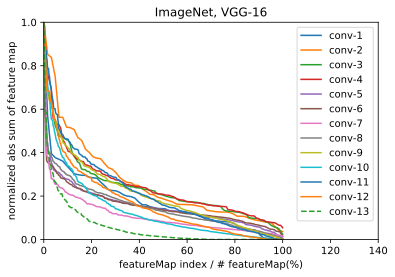

In [213]:
featureMap_rank_figure(normalized_fm[0])

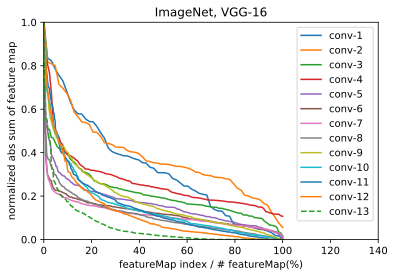

In [214]:
featureMap_rank_figure(normalized_fm[1])

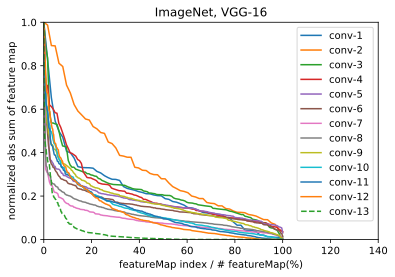

In [215]:
featureMap_rank_figure(normalized_fm[2])

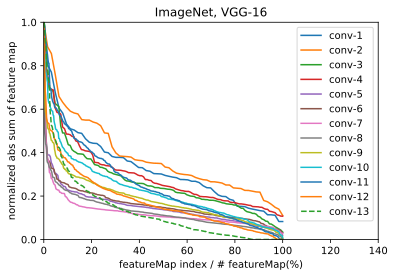

In [216]:
featureMap_rank_figure(normalized_fm[3])

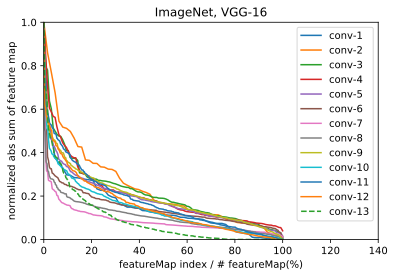

In [217]:
featureMap_rank_figure(normalized_fm[4])

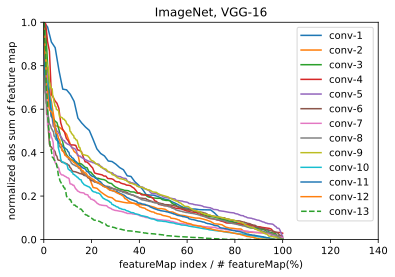

In [218]:
featureMap_rank_figure(normalized_fm[5])

## 3. Feature Map, Another Class

In [219]:
# Load data
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
reverse_mean = [-0.485, -0.456, -0.406]
reverse_std = [1/0.229, 1/0.224, 1/0.225]
train_transform = None
train_transform = transforms.Compose([                                                                                                                                
    transforms.Resize((224, 224), interpolation=Image.BILINEAR),                                                                                              
    # transforms.RandomCrop(input_size),                                                                                                                              
    # transforms.RandomHorizontalFlip(),                                                                                                                              
    # transforms.ColorJitter(brightness=0.4, saturation=0.4, hue=0.4),                                                                                                
    transforms.ToTensor(),                                                                                                                                            
    transforms.Normalize(mean, std)                                                                                                                                   
       ])         
trainset = imagenet.ImageNet(root="/media/lincolnzjx/HardDisk/Datasets/", is_train=True, transform=train_transform)

trainset.set_data([951], 30)
#image, label, imgs_path = trainset
imgs_path = []                                                                                                                                                            
images = []
labels = []
for img, label, img_path in trainset:                                                                                                                                     
    images.append(img.unsqueeze(0))                                                                                                                                       
    labels.append(label)                                                                                                                                                  
    imgs_path.append(img_path)  

Len of new dataset is :30


In [220]:
original_image = torch.cat(images, dim=0).to(device)

In [221]:
conv_output_indexes = [1, 3, 6, 8, 11, 13, 15, 18, 20, 22, 25, 27, 29]
conv_output_indexes_dict = dict(zip(conv_output_indexes, range(len(conv_output_indexes))))
print(conv_output_indexes_dict)

{1: 0, 3: 1, 6: 2, 8: 3, 11: 4, 13: 5, 15: 6, 18: 7, 20: 8, 22: 9, 25: 10, 27: 11, 29: 12}


In [222]:
layer_output, layer_max_min = obtain_features_map(original_image, net.model.features, layer_output_indexes=conv_output_indexes)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([30, 64, 224, 224])
1 ReLU(inplace=True) torch.Size([30, 64, 224, 224])
Index:1, ReLU(inplace=True)
0.0 17.237799
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([30, 64, 224, 224])
3 ReLU(inplace=True) torch.Size([30, 64, 224, 224])
Index:3, ReLU(inplace=True)
0.0 28.915472
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) torch.Size([30, 64, 112, 112])
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([30, 128, 112, 112])
6 ReLU(inplace=True) torch.Size([30, 128, 112, 112])
Index:6, ReLU(inplace=True)
0.0 37.898804
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) torch.Size([30, 128, 112, 112])
8 ReLU(inplace=True) torch.Size([30, 128, 112, 112])
Index:8, ReLU(inplace=True)
0.0 77.28725
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) torch.Size([30, 128, 56, 56])
10 Conv2

In [223]:
normalized_fm = normalize_feature_map(layer_output)

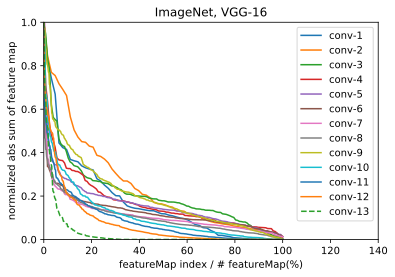

In [224]:
featureMap_rank_figure(normalized_fm[0])

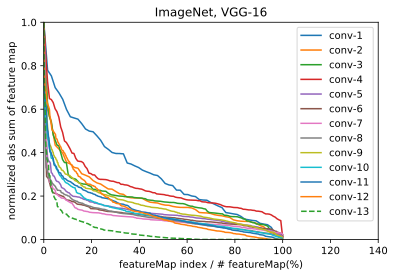

In [225]:
featureMap_rank_figure(normalized_fm[1])

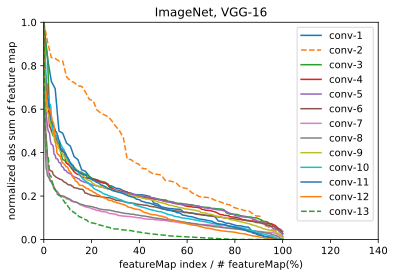

In [233]:
featureMap_rank_figure(normalized_fm[2])

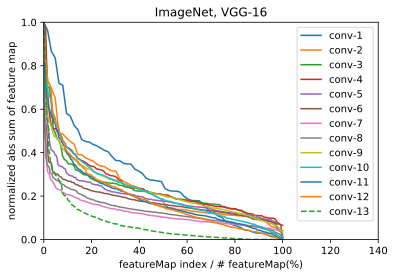

In [231]:
featureMap_rank_figure(normalized_fm[3])

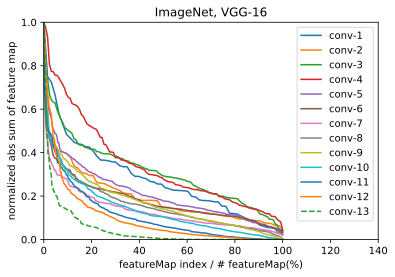

In [230]:
featureMap_rank_figure(normalized_fm[4])

In [240]:
import torchvision
vgg16 = torchvision.models.vgg16().features

In [241]:
for index, layer in enumerate(vgg16):
    print(index, layer)

0 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 ReLU(inplace=True)
2 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 ReLU(inplace=True)
4 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 ReLU(inplace=True)
7 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 ReLU(inplace=True)
9 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 ReLU(inplace=True)
12 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 ReLU(inplace=True)
14 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 ReLU(inplace=True)
16 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
17 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
18 ReLU(inplace=True)
19 Conv2d(512, 512, kernel_size=(3, 3)

In [239]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1